In [14]:
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

In [15]:
class DiganesDataset(Dataset):
    """Diganses seals dataset."""

    def __init__(self, csv_file, root_dir, category=None, min_label_count=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            category (string, optional): Optional ilustration type, can be 'drawing' or 'photo'.
            min_label_count (int, optional): Minimum number of instances per label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        labels = pd.read_csv(csv_file)
        
        #filter only specifc type of ilusration
        if category:
            labels = labels[labels.category == category]
            labels = labels.reset_index(drop=True)
        
        labels = labels.drop('category', axis=1)
            
        if min_label_count:
            #remove labels with insufficent number of samples
            count_per_label = labels.iloc[:,2:].sum()
            columns_to_remove = count_per_label[count_per_label < min_label_count].axes[0]       
            labels = labels.drop(columns_to_remove, axis=1)  
            
            #check if any row is left without a label
            labels_per_image = labels.iloc[:,2:].sum(axis=1)
            zero_label_rows = np.nonzero(labels_per_image.to_numpy() == 0)[0]
            labels = labels.drop(zero_label_rows)
            
            labels = labels.reset_index(drop=True)
        
        self.labels_name = labels.columns[2:]
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.loc[idx, "img_name"])
        image = io.imread(img_name)
        labels = np.array(self.labels.iloc[idx, 2:])
 
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def show_image(self, image, labels):
        """Show image with labels"""
        img_label_names = self.labels_name[(labels > 0)].tolist()
        plt.imshow(image)
        plt.title(img_label_names)

Index(['ant', 'bird', 'bull', 'bull-man', 'crescent', 'cross',
       'disc-in-crescent', 'dog', 'drill hole(s)', 'fish-man', 'goat', 'god',
       'god or man', 'goddess', 'grasshopper', 'horizontal/vertical line(s)',
       'inscription (framed)', 'inscription (unframed)', 'king', 'lion', 'man',
       'priest', 'rhomb', 'rosette', 'six-curled hero', 'sun-god',
       'suppliant goddess', 'tree', 'vessel', 'warring goddess'],
      dtype='object')


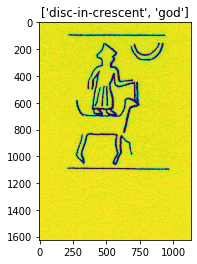

In [19]:
label_file = '/Users/atad/Desktop/DIGANES/diganes/diganens.csv'
pic_dir = '/Users/atad/Desktop/DIGANES/pics'
diganes = DiganesDataset(label_file, pic_dir, category='drawing', min_label_count=250)

sample = diganes[400]
#sample['labels']
diganes.show_image(sample['image'], sample['labels'])
print(diganes.labels_name)
#sample['labels'] > 0